# Deep learning

## 1. Introduction

Examples and code for explaining machine learning and deep learning concepts.

This tutorial has been prepared by:
- [Andrew Rohl](http://computation.curtin.edu.au/about/steering-committee/director/)
- [Shiv Meka](http://computation.curtin.edu.au/about/computational-specialists/humanities/)
- [Kevin Chai](http://computation.curtin.edu.au/about/computational-specialists/health-sciences/)

from the [Curtin Institute for Computation](http://computation.curtin.edu.au) at Curtin University in Perth, Australia for the [7th International Conference on Smart Computing & Communications (ICSCC 2019)](http://icscc.online/) hosted at Curtin University in Miri, Sarawak, Malaysia on the 28-30 June 2019.

## 2. Installation

Install the necessary python dependencies. Some packages marked with an __^__ are available on <a href='https://www.anaconda.com/distribution/' target='_blank'>Anaconda's Python </a>distribution by default and for the others you can use a package installer - `pip` or `easy_install`: 

- Python 3 ^
- jupyter ^
- numpy ^
- scipy ^
- PIL ^
- tarfile ^
- requests ^
- tensorflow
- keras
- plotly

In [ ]:
# Check installed packages
!pip list

Import the libraries needed for the notebook.

In [2]:
# Import all essential subroutines for data processing and visualization
from workshop import * 

# Plotting libraries
import plotly.graph_objs as go 
from plotly.offline import plot, iplot, init_notebook_mode 
import matplotlib.pyplot as PyPlot

# Scientific library needed for most exercises
import numpy as np

# Machine learning functions
from keras.layers import Input, Dense
from keras.models import Model

# Plot graphs in the notebook itself w/o opening a new window
init_notebook_mode(True)
%matplotlib inline 

Using TensorFlow backend.


## 3. Curve fitting

In [3]:
# Display slides for the section
PDF('assets/exercise1.pdf', 3, 600, 800)

### 3.1 Measure distance / loss

In [5]:
# Mean-squared distance
def mse(inp, pred):
    '''
    Mean-squared error (MSE) amplifies the loss between predicted value and ground truth.
    It just is squared difference between the two.
    This 'amplification' helps in faster convergence in regression problems as compared
    to just difference between the values - also called Mean Average error.
    '''
    return np.sum(np.square(inp - pred)) #inp: Inputs and pred: predictions from your test model

# Computes error between actual and predicted values
def distance(a, X, pred, values):
    '''
    MSE (look at the function above) quantifies loss between ground truth and predicted values. Now, these
    predictions are based on something called a hypothesis - a function we use
    to hypothesize / estimate the trend. Visualize the data first before 
    engineering a hypothesis function.
    
    '''
    inp = np.exp(a[0] * x) * np.sin(a[1] * x) #<-----Tweak the hypothesis here
    msd = mse(inp, pred) #Error between prediction and hypothesis for values a,b
    values.append([inp]) 
    print ("Variables (a, b):", a ,"Loss:", msd) #Iterates over a,b to find the best loss
    return msd
  
def visualize(optim_step):
    '''
    Function that is used to plot the goodness of fit for each optimization timestep.
    '''
    import matplotlib.pyplot as pyp
    global x, y, values
    pyp.plot(x, y, x, np.array(values[optim_step]).T[:,0])

### 3.2 Trump dataset

In [25]:
global x, y # Accessible across the notebook
data = np.load('assets/trump.npy')

# y = f(x)
x = data.item(0)['x']
y = data.item(0)['y']

Let's start by visualising the dataset. a.k.a. data exploration

In [27]:
iplot({"data": [go.Scatter(x=x, y=y)]})

Can you think of a `hypothesis` i.e a mathematical function to approximate Trump's mood swings?

Let's use a traditional optimiser to learn a good function to fit the data.

In [31]:
import scipy.optimize as opt

# A placeholder to log loss vs. time
global values
values = [] 

# To change the hypothesis, have a look at the function - 'distance'. 
# Minimizes the distance between prediction and expected using conjugate gradient
opt.minimize(distance, (0.0, 0.0), (x, y, values), method='cg') 

Variables (a,b): [0. 0.] Loss: 6.004291944987037
Variables (a,b): [1.49011612e-08 0.00000000e+00] Loss: 6.004291944987037
Variables (a,b): [0.00000000e+00 1.49011612e-08] Loss: 6.004291938779205
Variables (a,b): [0. 0.] Loss: 6.004291944987037
Variables (a,b): [0.         0.41660058] Loss: 58.70311736130956
Variables (a,b): [0.         0.41660058] Loss: 58.70311736130956
Variables (a,b): [1.49011612e-08 4.16600585e-01] Loss: 58.70312175591401
Variables (a,b): [0.        0.4166006] Loss: 58.70311899187442
Variables (a,b): [0.         0.00032053] Loss: 6.004213480596145
Variables (a,b): [0.         0.00032053] Loss: 6.004213480596145
Variables (a,b): [1.49011612e-08 3.20529432e-04] Loss: 6.004213480595306
Variables (a,b): [0.         0.00032054] Loss: 6.004213479508719
Variables (a,b): [1.67639483e-06 2.49245060e-03] Loss: 6.006583509170813
Variables (a,b): [1.67639483e-06 2.49245060e-03] Loss: 6.006583509170813
Variables (a,b): [1.69129599e-06 2.49245060e-03] Loss: 6.006583509425027
Var

     fun: 1.1180838617850567e-14
     jac: array([-6.69398852e-09, -3.12479503e-07])
 message: 'Optimization terminated successfully.'
    nfev: 266
     nit: 16
    njev: 66
  status: 0
 success: True
       x: array([-1.02000001, 10.19999994])

### 3.3 Plot the losses

In [32]:
# Visualize optimization steps
# This only works on a laptop - Google blocks ipywidgets 
_ = interact(visualize,optim_step = widgets.IntSlider(min=0, max=max(0, len(values) - 1), step=10, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='optim_step', max=265, step=10),…

## 4: Machine learning

In the previous example, we cheated (in a way) as we knew the functional form of the curve $(sin(a_{0}x) \cdot e^{-a_{1}x}))$, and ran a parametric optimisation. 

This section demonstrates a 'magical' hypothesis function that could be used to predict almost anything.

In [4]:
PDF('assets/exercise2.pdf', 1, 600, 800)

### 4.1 Neural networks

Demostrate logistic regression, feature engineering, shallow and deep neural networks on the [TensorFlow playground](https://playground.tensorflow.org).

### 4.2 Fitting to random data 
Generate a random dataset with two input features: mood swings and blood pressure

In [51]:
# Generate two random features, and a random output. Is there a model that could fit?
np.random.seed(1)
mood = np.random.uniform(-30, 10, 2000) # Mood -- 2000 is sample size
mood = (mood-np.mean(mood)) / np.std(mood)  # Standardize data
bp = np.random.uniform(-30, 10, 2000) # feature 2 - blood pressure?
bp = (bp - np.mean(bp)) / np.std(bp) # Standardize data? 
output = generate_ground_truth(mood, bp)
inputs = np.rollaxis(np.array([mood, bp]), 1)

# Plotting the input features as well as output
iplot({"data": [
    go.Scatter(x=np.arange(len(inputs)), y=mood,name='mood'), 
    go.Scatter(x=np.arange(len(inputs)), y=bp,name='blood pressure'),
    go.Scatter(x=np.arange(len(inputs)), y=output,name='output')]})

Let's define a simple 4 layer neural network

In [114]:
from keras.layers import BatchNormalization,Dense,Input
from keras.models import Model
import numpy as np

#The function below generates a neural network model with n_layers
def dense_model(n_layers):
    np.random.seed(1)
    inp = Input(shape=[2]) #two features - mood, blood-pressure
    out = []
    for i in range(n_layers):
        out = Dense((12, 1)[i == n_layers-1], activation='relu')((out, inp)[i==0])
    return Model(inp,out)

model = dense_model(4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 12)                36        
_________________________________________________________________
dense_31 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_32 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 13        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


Now we want to learn good values for the weights and biases in our neural network. Let's try the same traditional optimisation strategy we used for the curve fitting example.

### 4.3 Optimisation

In [115]:
# Run optimization using full hessian
# Note: This should take about 2 mins to complete
# You can interrupt the notebook kernel if it takes too long
viz_loss = []
%time opt.minimize(optimize_cg, convert_weights(model, model.get_weights()),(model, inputs, output, viz_loss), method='cg', options={'maxiter': 1})

CPU times: user 1min 49s, sys: 18.6 s, total: 2min 8s
Wall time: 1min 27s


     fun: 1.9587034431774075
     jac: array([ 0.00000000e+00, -6.32483214e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -6.25003874e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -5.80641031e-02,
        0.00000000e+00, -3.14047292e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.41370308e-02,
        0.00000000e+00,  0.00000000e+00,  1.34616941e-01,  0.00000000e+00,
       -1.55980363e-01,  5.35556674e-03,  0.00000000e+00, -5.34354448e-02,
       -2.60632098e-01, -2.45967895e-01,  4.30523157e-02, -8.06768537e-02,
        8.63064229e-02, -7.43746758e-03, -1.93016887e-01, -1.67768151e-02,
       -3.41450274e-02,  0.00000000e+00,  1.43072158e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.31290418e-02,
        0.00000000e+00, -2.15499848e-02,  5.30619919e-03,  0.

In [116]:
# Plot predictions and ground truth values
# Note: zoom in the plot see the differences
iplot({"data": [go.Scatter(x=np.arange(len(inputs)), 
                           y=model.predict(inputs).reshape([2000]),
                           name='predictions'),
                go.Scatter(x=np.arange(len(inputs)), 
                           y=output,name='ground truth')]})

Unfortunately, the optimiser was unable to learn good weights and bias values for the neural network to accurately predict the ground truth. This highlights the limitations of using traditional optimisation methods for fitting / training neural networks. 

It should be noted that this example model is very small only comprising of 361 parameters. In practice, it is not uncommon to train neural networks with 100s of thousands to 10s of millions of parameters for complex tasks such as image classification and object detection.

### 4.4 Backpropagation
Let's re-train the model using a different optimisation strategy called <b>backpropagation</b> (backprop for short). Backprop has the advantage of optimising (updating) values for a given neural network layer with only its connected neighbours / layers. 

Technically speaking, this causes the hessian to be sparse as parameters are decoupled from other non-neighbouring parameters in the graph which results in faster optimisation.

To illustrate, we can define our neural network as:

$network=f_{1}(\ f_{2} (\ f_{3}(\ f_{4}(x)))))$

where $x$ represents our input data and the function $f_{n}$ represents the _nth_ layer in the network. For example, parameters in the second layer $f_{2}$ only interact with parameters $f_{1}$ and $f_{3}$.


In [111]:
# Reinitalise the model (i.e. reset weights)
model = dense_model(4)
# Use the adam (ADAptive Momentum) optimisation algorithm 
# with the mse (mean square error) loss function
model.compile(optimizer='adam', loss='mse')

In [112]:
# Train the model for 100 epochs (number of training iterations through the whole dataset)
# Note: This should take about 1min to complete training
%time model.fit(inputs, output, epochs=10, batch_size=20, validation_split=0.1)

Train on 1800 samples, validate on 200 samples
Epoch 1/10
1800/1800 [==============================] - 1s 313us/step - loss: 32.1872 - val_loss: 23.8726
Epoch 2/10
1800/1800 [==============================] - 0s 66us/step - loss: 10.2684 - val_loss: 3.8759
Epoch 3/10
1800/1800 [==============================] - 0s 67us/step - loss: 2.9894 - val_loss: 2.1408
Epoch 4/10
1800/1800 [==============================] - 0s 61us/step - loss: 1.7510 - val_loss: 1.3446
Epoch 5/10
1800/1800 [==============================] - 0s 62us/step - loss: 1.1881 - val_loss: 0.9485
Epoch 6/10
1800/1800 [==============================] - 0s 63us/step - loss: 0.9085 - val_loss: 0.7837
Epoch 7/10
1800/1800 [==============================] - 0s 60us/step - loss: 0.7544 - val_loss: 0.6641
Epoch 8/10
1800/1800 [==============================] - 0s 59us/step - loss: 0.6390 - val_loss: 0.5522
Epoch 9/10
1800/1800 [==============================] - 0s 61us/step - loss: 0.5368 - val_loss: 0.4667
Epoch 10/10
1800/1800 

In [113]:
# Plot predictions and ground truth values
# Note: zoom in the plot see the differences
iplot({"data": [
    go.Scatter(x = np.arange(len(inputs)),y = model.predict(inputs).reshape([2000]), name='predictions'),
    go.Scatter(x = np.arange(len(inputs)), y = output,name='ground truth')]})

There are many optimisation algorithms we can use for training our neural networks with backprop. Each type has advantages and disadvantages in terms of speed and stability for a given dataset and problem. Some of the most popular algorithms used in training neural networks are shown below.

<img src='assets/optimizers.gif' width='50%'>
<center>Source: Sebastian Ruder (2018) <a href='http://rudio.io' target='_blank'>http://rudio.io</a></center>

## 5. Convolutions

The neural network we trained in the previous section is referred to as a vanilla / multi-layer perception (MLP) network. However, there are other types of networks we can build for different types of datasets and problems. For example, a Convolutional Neural Network is a popular type of network used for performing machine learning tasks on image and signal data (e.g. audio). 

A CNN is comprised of convolution layers. A convolution is a mathematical operation where some input data (e.g. signal, image) is convolved (transformed) by a convolutional filter (a matrix of numbers).

In [5]:
PDF("assets/exercise3.pdf", 1, 600, 800)

Helper functions used for the interactive visualisations 

In [93]:
# Ignore this function - this is only used to visualize
from PIL import Image # Library to load images
def Infer(Num_filters, Num_layers, max_pool=False):
    global X, parameters, max_pooling
    K.clear_session()
    inp = Input(shape=(1024, 1024, 3))
    out = []
    N = Num_layers
    parameters = []
    max_pooling = []
    # Conv-Maxpool - fully connected deck
    for i in range(N):
        out = Conv2D(Num_filters, (3, 3), activation='relu')((out, inp)[i==0])
        if max_pool:
            out = MaxPool2D(2)(out)
    out = Flatten()(out)
    
    for i in range(5):
        out = Dense((2, 12)[i != 4], activation=('sigmoid', 'relu')[i != 3])(out)

    model = Model(inp,out)
    
    #how many trainable parameters?
    params = int(np.sum([K.count_params(i) for i in set(model.trainable_weights)]))

    #For plotting
    parameters.append(params)
    max_pooling.append(int(max_pool))
    print ("Parameters:",params)
    
    plot_model(model, to_file='assets/model.png')

    return HTML('<img src="assets/model.png?'+str(np.random.randint(0,1E8))+' height="120" width="100">')

def Generate_maps(kernel_size=3, stride=1):
    K.clear_session()
    image='assets/lake.jpg'
    img=np.expand_dims(np.array(PIL.Image.open(image)), 0)
    inp=Input(shape=(None, None, 3))
    out=Conv2D(4, int(kernel_size), strides=int(stride), padding='same')(inp)
    out=Conv2D(1, int(kernel_size), strides=int(stride), padding='same')(out)
    model=Model(inp,out)

    return display(Image.fromarray(np.uint8(model.predict(img))[0,:,:,0]))

### 5.1 Convolutional neural network
Build a three layer CNN that takes a image (2D data) and outputs a 1-channel image.

In [118]:
from keras.layers import Conv2D
import keras.backend as K
import PIL

np.random.seed(17)
inp=Input(shape=(None,None,3))
out=Conv2D(4,3,padding='same')(inp)
out=Conv2D(1,3,padding='same')(out)
model=Model(inp,out)

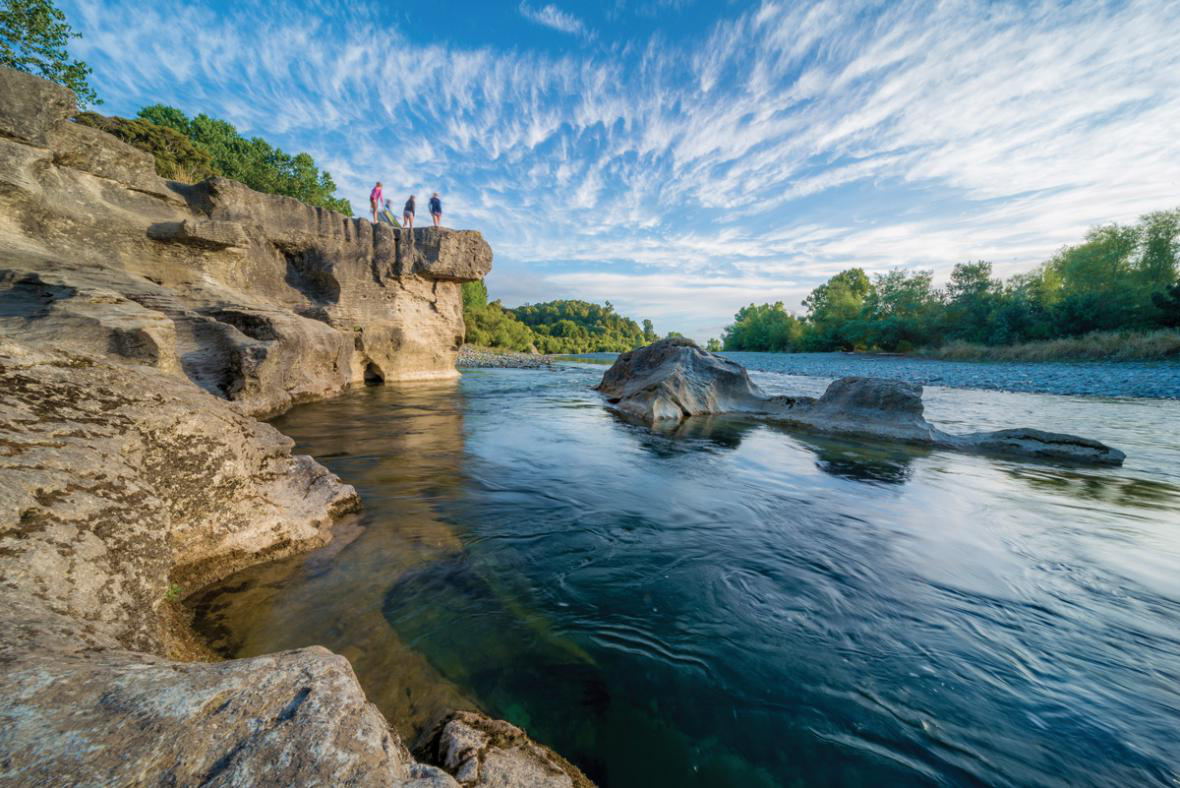

In [119]:
# Open and display an image using PIL Image library
Image.open('assets/lake.jpg')

In [120]:
img=np.expand_dims(np.array(Image.open('assets/lake.jpg')), 0) 

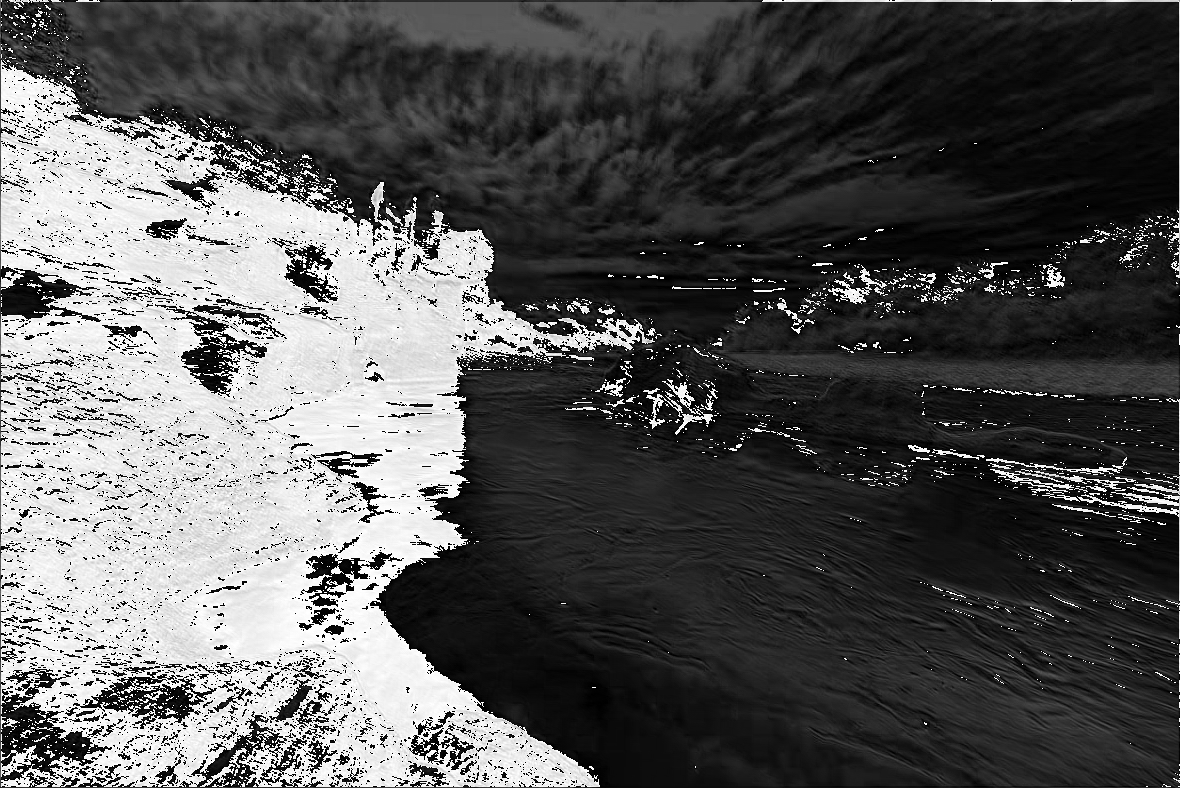

In [121]:
#You may ignore the reshaping procedure as PIL.Image expects just 2 dimensions [X,Y] pixels to print the image
Image.fromarray(np.uint8(model.predict(img)[0, :, :, 0]))

### 3.2 Getting a sense of stride and the number of filters

Let us try a couple more images. Please click the button underneath to initialize model with random weight initialization.

In [97]:
button=widgets.interact_manual(Generate_maps,
                               kernel_size=widgets.IntSlider(min=2,max=10,step=1, continuous_update=False),
                              stride=widgets.IntSlider(min=1,max=10,step=1, continuous_update=False))


interactive(children=(IntSlider(value=2, continuous_update=False, description='kernel_size', max=10, min=2), I…

<hr>
In the previous exercise, what do you see when you:
<ul>
<li>
Keep the stride at 1 and change kernel size?
<select>
<option><b>Noticeable</b> change in image size</option>
<option>The prediction becomes much slower</option>
<option>No noticeable difference</option>
</select>
</li>
<li>
Change both kernel size and stride
<div>
<input type='checkbox' name='No'> Images get blurier with increasing kernel size
<br><input type='checkbox'> No noticeable change
<br><input type='checkbox'> Faster prediction for higher strides
</div>
</li>

<li>
Keep the stride fixed and change the kernel
<select>
<option>Images become blurier (on an average) with increasing kernel size</option>
<option>No noticeable difference</option>
</select>
</li>

</ul>


#### The model isn't trained yet. The output images are based on random initial weights

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 4)     112       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     37        
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


### 3.3 A yes or a no output and the trainable variables in the network

What good does it do if we just have images as output. The only applicable areas where you would want just images is say - "segmenting" tumors in MRIs/CTs. What if we want a yes/no answer? The kind of a problem we are looking at is a classification problem where in one needs a decisive yes or no.¶

In [98]:
from keras.layers import Input,Conv2D,Flatten,Dense,Conv2D,MaxPool2D
from keras.utils import plot_model

np.random.seed(10)

inp=Input(shape=(img.shape[1],img.shape[2],3))
out=Conv2D(4,3,padding='same')(inp)
out=Flatten()(out) #<----What does this do?

#Add a Dense layer with 1-output and build a model

out=Dense(1,activation='sigmoid')(out) #<---What does this do?
model=Model(inp,out)

In [99]:
out=Dense(1)(out) #<---What does this do?
model=Model(inp,out)

In [100]:
model.predict(img)
#Now add the Dense layer (in the previous cell) and then run the prediction again

#Add this to the last layer:
#Dense(1,activation='sigmoid')
#Re-run the prediction for seeds - [10,15]
#What do you infer?

array([[0.]], dtype=float32)

In [101]:
#How many variables? Compare it with the previous summary. What just happened?
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 788, 1180, 3)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 788, 1180, 4)      112       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3719360)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3719361   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 3,719,475
Trainable params: 3,719,475
Non-trainable params: 0
_________________________________________________________________


<hr>
When a dense layers is added, the number of trainable parameters:
<select>
<option>Increased by orders of magnitude</option>
<option>Decreased</option>
<option>Remained same</option>
</select>


In [102]:
#Why do we need i) deeper networks and ii) pooling layers?

_=widgets.interact(Infer,Num_filters=widgets.IntSlider(min=2,max=35,step=1, continuous_update=False),
                 Num_layers=widgets.IntSlider(min=1,max=8,step=1, continuous_update=False),
                 max_pool=[('True',True),('False',False)])

interactive(children=(IntSlider(value=2, continuous_update=False, description='Num_filters', max=35, min=2), I…

<hr>
<h4>Fill in the boxes below with the number of parameters for each of the cases as you change the model parameters</h4>
<ul>
<li>Increase the number of filters by keeping num_layers=1: <input type="text"></li>
<li>Keep the number of layers at max., num_layers=1, and turn on max_pool:<input type="text"></li>
<li>Keep the number of layers at max., increase the number of layers, and turn on max_pool:<input type="text"></li>
</ul>

In [ ]:
import glob
@interact
def showimage(filename=sorted(glob.glob('meteors_validation/*/*jpg'))):
    img=Image.open(filename)
    img_arr=np.array(img)
    print ("Prediction: ",np.round(model.predict(img_arr.reshape([1,
                                                                  img_arr.shape[0],
                                                                  img_arr.shape[1],1]))))
    return img